<a href="https://colab.research.google.com/github/ericr6/platform_analysis/blob/main/reach_campaign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reach Campaign 

In [ ]:
# @title import stuffs
import requests
import json
import csv
from datetime import datetime, timedelta
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
# @title Common Functions
# Function to convert Hexa String to Text
def hex_to_string(value):
    if not value:
        return value

    bytes_from_hex = bytes.fromhex(value[2:])
    return bytes_from_hex.decode('utf-8')

def filter_by_time_interval(data_list, date_begin, date_end):
    # Convert date_begin and date_end strings to datetime objects
    #date_begin = datetime.strptime(date_begin, '%Y-%m-%d %H:%M:%S')
    #date_end = datetime.strptime(date_end, '%Y-%m-%d %H:%M:%S')

    # Filter data_list based on timestamp falling within the specified time interval
    filtered_data = [row for row in data_list if date_begin <= datetime.utcfromtimestamp(int(row[5])) <= date_end]
    return filtered_data



def get_api_data_iexec_interval(url_query, query, global_skip, date_begin=None, date_end=None):
    total_data = []
    are_data = True
    detected = False
    skip = 0
    while are_data and skip < 200000 or not detected:

        # Construct the query with skip parameter and optional date filters
        query_iter = query.replace("skip_param", str(global_skip + skip))

        options = {
            'headers': {'Content-Type': 'application/json'},
            'data': '{"query": "' + query_iter + '"}',
        }

        response = requests.post(url_query, **options)

        # Check if the response contains valid JSON data
        response.raise_for_status()
        data = response.json()

        array_data = data.get('data', {}).get('taskInitializes', [])

        grouped = [
            [
                e['task']['id'],
                e['task']['deal']['app']['name'],
                hex_to_string(e['task']['deal']['app']['multiaddr']),
                e['task']['deal']['tag'],
                e['task']['status'],
                #pd.to_datetime(int(e['task']['timestamp']) * 1000000).strftime('%Y-%m-%d %H:%M:%S'),
                e['task']['timestamp'],
                e['task']['deal']['workerpool']['id'],
                e['task']['deal']['requester']['id']
            ]
            for e in array_data
        ]

        grouped = filter_by_time_interval(grouped, date_begin, date_end)

        total_data.extend(grouped)
        skip += 500
        _are_data = len(grouped) > 0
        if _are_data > 0 and are_data:
 #           print ("detected is true")
            detected = True
        are_data = len(grouped) > 0
        print("i= " + str(global_skip + skip) + " are_data: " + str(are_data) + "_are_data: " + str(_are_data) + " grouped size " +  str(len(grouped)) + " array_data size: " + str(len(array_data))  )
    return total_data



# Actualize data
url_query_bellecour = 'https://thegraph.bellecour.iex.ec/subgraphs/name/bellecour/poco-v5'
query = '{\
                taskInitializes(first:500, skip: skip_param, orderBy: timestamp, orderDirection: desc){\
                  task{\
                    id,\
                    deal{\
                      requester {\
                        id\
                      }\
                      app{\
                        name\
                        multiaddr\
                      }\
                      dataset{\
                        name\
                      }\
                      workerpool{\
                        id\
                         }\
                      tag\
                    }\
                    status,\
                    timestamp\
                  }\
                }\
              }'




In [ ]:
date_end = datetime.now()
date_begin = date_end - timedelta(days=30)

print ("Period to retrieve:", date_begin, date_end)

api_data = get_api_data_iexec_interval(url_query_bellecour, query, 0, date_begin, date_end)
df_tasks_30d = pd.DataFrame(api_data, columns=["TASK_ID","APP NAME", "APP MULTIADDR", "TAG", "STATUS", "DATE", "WORKERPOOL ID", "REQUESTER ID"])
df_tasks_30d["DATE"] = [datetime.utcfromtimestamp(int(x)) for x in df_tasks_30d["DATE"]]

print("Period observed", df_tasks_30d["DATE"].min(), df_tasks_30d["DATE"].max())
print("dataset length: " + str(df_tasks_30d.shape[0]))

#print(filename)


In [ ]:
df_tasks_30d.dtypes


TASK_ID                  object
APP NAME                 object
APP MULTIADDR            object
TAG                      object
STATUS                   object
DATE             datetime64[ns]
WORKERPOOL ID            object
REQUESTER ID             object
dtype: object

In [ ]:
df_tasks_30d

,TASK_ID,APP NAME,APP MULTIADDR,TAG,STATUS,DATE,WORKERPOOL ID,REQUESTER ID
0,0xe345b2fc524718e3e940d659dafec774a87620b9f3e5...,tee-python-hello-world:8.0.3-gramine,docker.io/iexechub/tee-python-hello-world:8.0....,0x00000000000000000000000000000000000000000000...,ACTIVE,2024-03-18 07:42:05,0xca76ab007f8a3fb64076851bb01acc99fc26d27b,0x5d62abd17f0a7f1004c981d5cff24c5a88d849f5
1,0xc53a373bd6b8555657e6237196c81106c713e1c4fb88...,python-hello-world:8.0.0-sconify-5.7.5-v14-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-03-18 07:36:15,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c
2,0xd62f49350db4a77ce3203fb2bf1e238d015410b4269f...,python-hello-world:8.0.0-sconify-5.7.5-v14-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-03-18 07:34:30,0xdb214a4a444d176e22030be1ed89da1b029320f2,0x7d695b9a362e15090ce26711808bc89c18efa70f
3,0x47b40d3b40e84a72fda63c8a1fddaa1ac0d5d8f603d0...,python-hello-world:8.0.0-sconify-5.7.6-v15-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-03-18 07:26:30,0xca76ab007f8a3fb64076851bb01acc99fc26d27b,0x3d60589cb7a862e3001b8e7eff1ec248d1f16a18
4,0xeb15f32de5346781efd4ba7efd773a1394b18ed6637e...,python-hello-world:8.0.0-sconify-5.7.6-v15-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-03-18 07:24:35,0xcfc79bf7ce221c504e281b42b4f50b1a0e692cb6,0x4d67487894140752d1a0dc81e77a578796e47255
...,...,...,...,...,...,...,...,...
11891,0x92f342d9cf93e523b65085e733ed4e483d71d258bd23...,python-hello-world:8.0.0-sconify-5.7.5-v14-pro...,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-02-17 07:57:05,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x6d6b5e88714263bbc6b4fa21a7328a7b947a302c
11892,0x23d8db34be141051fc23cfd0e8902effda5f2594c1c6...,python-hello-world:8.0.0-sconify-5.7.5-v14-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-02-17 07:55:15,0xdb214a4a444d176e22030be1ed89da1b029320f2,0x7d695b9a362e15090ce26711808bc89c18efa70f
11893,0x4302a2bbbffa1a1bc419e8f945c4020af25ce9d4b7ce...,tee-python-hello-world:8.0.3-gramine,docker.io/iexechub/tee-python-hello-world:8.0....,0x00000000000000000000000000000000000000000000...,COMPLETED,2024-02-17 07:54:05,0x0e7bc972c99187c191a17f3cae4a2711a4188c3f,0x8d6f890ea5d10134cd6b9777457eb75e76312304
11894,0x9b1e9d671d4da11f9c81de70774be7ae500cbdecce52...,python-hello-world:8.0.0-sconify-5.7.5-v14-debug,docker.io/iexechub/python-hello-world:8.0.0-sc...,0x00000000000000000000000000000000000000000000...,ACTIVE,2024-02-17 07:44:40,0xcfc79bf7ce221c504e281b42b4f50b1a0e692cb6,0x4d67487894140752d1a0dc81e77a578796e47255


<ipython-input-42-cd886085f281>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_staginghist['DATE'] = pd.to_datetime(df_staginghist['DATE'])
<ipython-input-42-cd886085f281>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_staginghist['Day'] = df_staginghist['DATE'].dt.to_period('d')


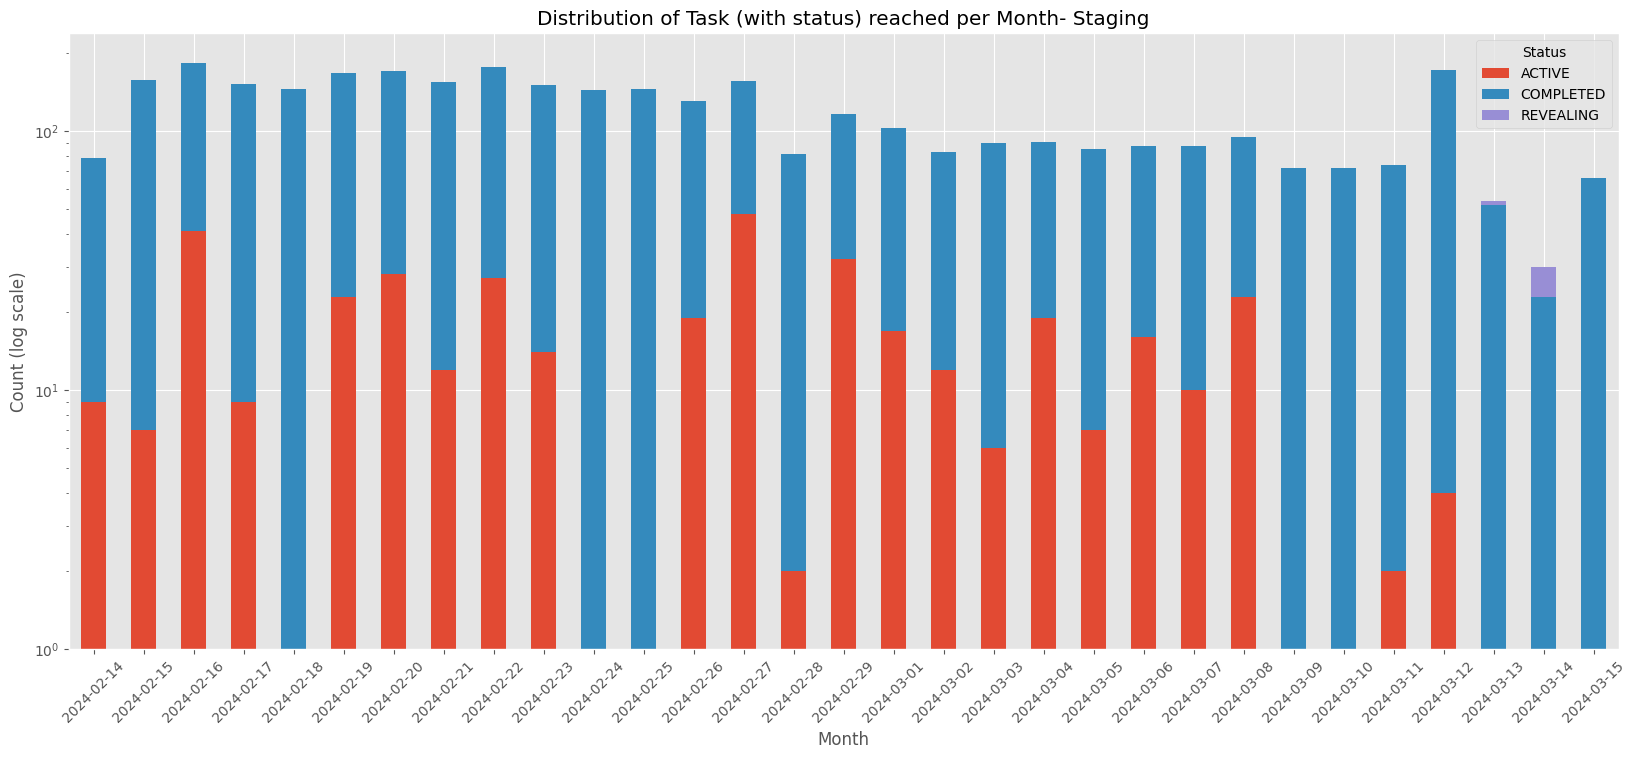

<Figure size 1920x1440 with 0 Axes>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'
# Convert DATE column to datetime if it's not already
# Replace 'specific_workerpool_id' with the actual ID of the worker pool you're interested in

def taskperday(df,workerpool_id, wpname, requester1, requester2):

    # Filter the DataFrame further for the specific worker pool
    df_taskday = df[df['WORKERPOOL ID'] == workerpool_id]
    len(df_taskday)

    df_taskday['DATE'] = pd.to_datetime(df_taskday['DATE'])
    # Define the date interval
    start_date = df_taskday['DATE'].min().strftime("%Y-%m-%d")
    end_date = df_taskday['DATE'].max().strftime("%Y-%m-%d")

    # Extract month from the DATE column
    df_taskday['Day'] = df_taskday['DATE'].dt.to_period('d')

    # Group by Month and STATUS, count occurrences
    status_counts = df_taskday.groupby(['Day', 'STATUS']).size().unstack(fill_value=0)

    # Plot
    status_counts.plot(kind='bar', stacked=True, figsize=(20, 8))

    plt.title('Tasks per day \n (Workerpool: {}) \n {} Start Date: {} | End Date: {}'.format(workerpool_id, wpname, start_date, end_date))
    plt.xlabel('Month')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title='Status')

    #Upscale resolution
    plt.figure(dpi=300)
    plt.show()

taskperday(df_tasks_30d,'0x0e7bc972c99187c191a17f3cae4a2711a4188c3f',"V8-prod","0xa1C2e8D384520c5D85Ab288598dC53a06db7dB5d","0x4E3754724b1389dfDaeCE950F27C5cfd537C4280") 


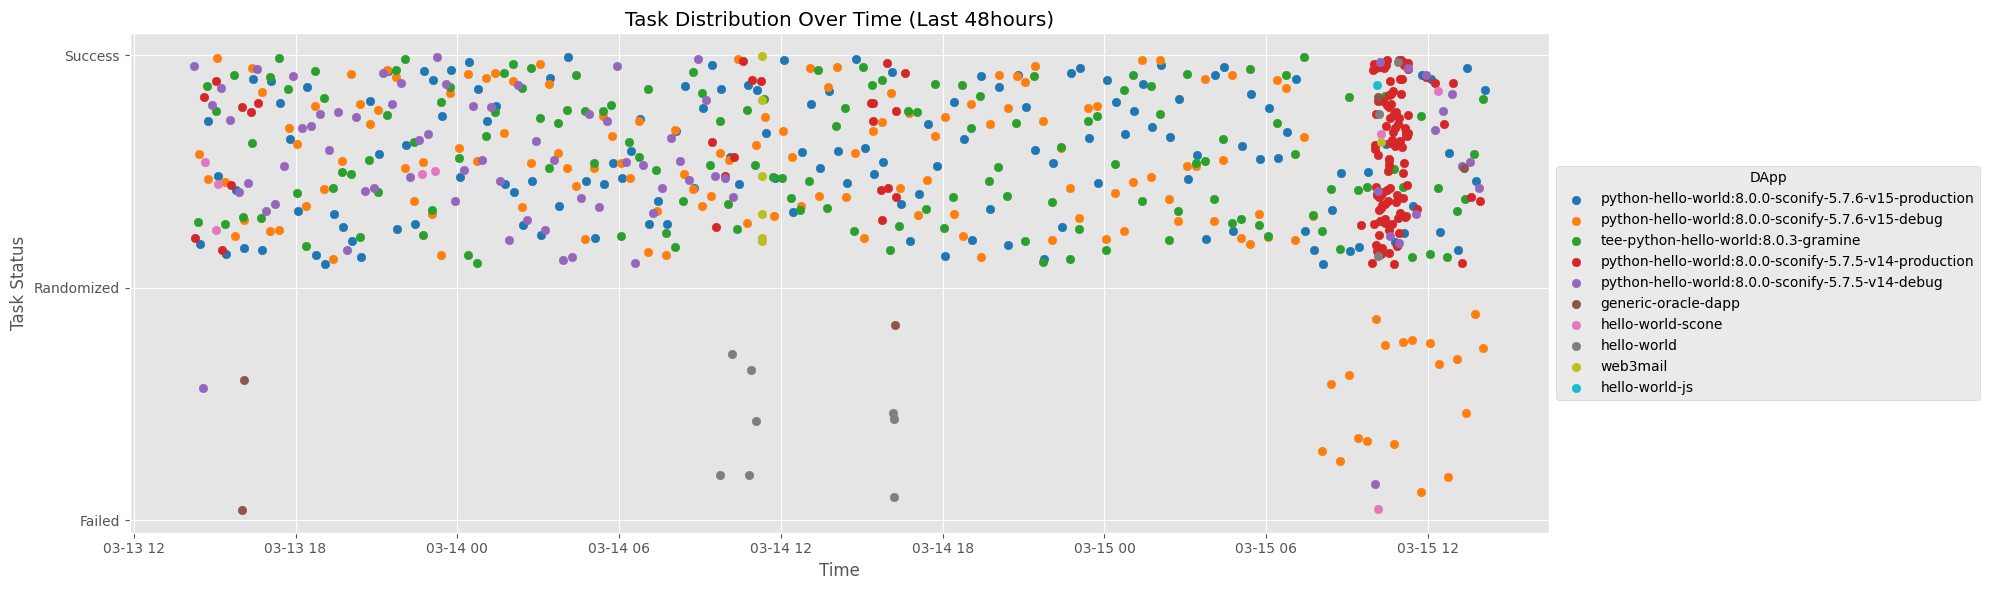

In [ ]:
# @title Show Time Distribution Successful and failed apps in the last days

import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import random

workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'

def success_repartition(df_tmp, workerpool, duration, wp_name):

    # Filter the DataFrame for the last day
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    df_datefiltered = df_tmp[(df_tmp['DATE'] >= start_date) & (df_tmp['DATE'] <= end_date)]
    # Filter the DataFrame further for the specific worker pool
    df_wpfiltered = df_datefiltered[df_datefiltered['WORKERPOOL ID'] == workerpool]

    # Create a dictionary to map DApp names to colors and marker types
    dapp_info = {}
    for i, dapp in enumerate(df_wpfiltered['APP NAME'].unique()):
        dapp_info[dapp] = {
            'color': plt.cm.tab20(i/len(df_wpfiltered['APP NAME'].unique())),
            'marker': 'o'  # Use the same marker type for each DApp
        }

    # Plot successful and unsuccessful points using the same marker type per DApp
    plt.figure(figsize=(20, 6))
    for dapp, info in dapp_info.items():
        dapp_df = df_wpfiltered[df_wpfiltered['APP NAME'] == dapp]
        success_mask = dapp_df['STATUS'] == 'COMPLETED'

        # Generate random y-coordinates for successful points in the range [0.1, 1]
        random_success_y = np.random.uniform(low=0.1, high=1, size=np.sum(success_mask))
        # Generate random y-coordinates for unsuccessful points in the range [-1, -0.1]
        random_failure_y = np.random.uniform(low=-1, high=-0.1, size=np.sum(~success_mask))

        # Plot successful points
        plt.scatter(dapp_df['DATE'][success_mask], random_success_y, color=info['color'], label=f'{dapp}', marker=info['marker'])
        # Plot unsuccessful points
        plt.scatter(dapp_df['DATE'][~success_mask], random_failure_y, color=info['color'], marker=info['marker'])

    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    title=('Tasks Success/fail distribution on \n {}  \n Workerpool: \n {} \n Last {} day(s) \n [{} -> {}]'.format(wp_name, workerpool, str(duration), start_date_str, end_date_str))
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Task Status')
    plt.yticks([-1, 0, 1], ['Failed', '', 'Success'])

    # Create a single legend for both success and failure
    plt.legend(title='DApp', loc='center left', bbox_to_anchor=(1, 0.5))

    plt.grid(True)
    plt.tight_layout()

    plt.show()

success_repartition(df_tasks_30d,workerpool_prod,1, "V8_prod")
success_repartition(df_tasks_30d,workerpool_prod,7, "V8_prod")
success_repartition(df_tasks_30d,workerpool_prod,30, "V8_prod")

In [ ]:
# @title Requester Activity Analysis for a defined app in last days

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
# Assuming df is your DataFrame containing the dApps data
# Filter the DataFrame based on the 'WORKERPOOL ID'
#workerpool_filter = ('0x0e7bc972c99187c191a17f3cae4a2711a4188c3f','0xdb214a4a444d176e22030be1ed89da1b029320f2')
#duration=(1,7,30);
workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'

def req_plot(df,workerpool_filter, duration, wp_name, app):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]


    # Group by app name and date to count the number of uses of each dApp on each date
    # req_usage = filteredapp_df.groupby(['REQUESTER ID', pd.Grouper(key='DATE', freq='D')]).size().unstack(fill_value=0)
    # Define colors for different statuses
    status_colors = {'COMPLETED': 'green', 'ACTIVE': 'red'}
    address_counts = filteredapp_df['REQUESTER ID'].value_counts()
 

    # Create a scatter plot with conditional coloring based on the status
    plt.figure(figsize=(20, 14))
    annotated_ids = set()  # Initialize a set to keep track of annotated IDs
    for status, color in status_colors.items():
        status_df = filteredapp_df[filteredapp_df['STATUS'] == status]
        plt.scatter(status_df['DATE'], status_df['REQUESTER ID'], marker='o', color=color, label=status)

        # Annotate points with the number of points for each address
        for idx, row in status_df.iterrows():
            if row['REQUESTER ID'] not in annotated_ids:  # Check if ID has not been annotated yet
                plt.annotate(str(address_counts[row['REQUESTER ID']]), (row['DATE'], row['REQUESTER ID']), textcoords="offset points", xytext=(-10,0), ha='right')
                annotated_ids.add(row['REQUESTER ID'])  # Add ID to annotated set

    # Set plot title and labels
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    plt.title('Scatter Plot of Requesters for \n DApp {} \n Workerpool: {} ; {}\n Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))

    plt.xlabel('Date')
    plt.ylabel('Requester')

    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45)

    # Show plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()


req_plot(df_tasks_30d, workerpool_prod, 30, "V8_prod", "web3mail")


In [ ]:
# @title Requester usage of specific app and workerpool in last days

import pandas as pd

workerpool_prod = '0x0e7bc972c99187c191a17f3cae4a2711a4188c3f'
workerpool_debug = '0xdb214a4a444d176e22030be1ed89da1b029320f2'

def req_count(df,workerpool_filter, duration, wp_name, app):
    end_date = datetime.now()
    start_date = end_date - timedelta(days=duration)
    date_filtered_df = df[(df['DATE'] >= start_date) & (df['DATE'] <= end_date)]
    filtered_df = date_filtered_df[date_filtered_df['WORKERPOOL ID'] == workerpool_filter]
    filteredapp_df = filtered_df[filtered_df['APP NAME'] == app]


    # Group by 'APP NAME' and 'STATUS' and count occurrences
    app_counts = filteredapp_df.groupby(['REQUESTER ID', 'STATUS']).size()

    # Reset index to make 'APP NAME' and 'STATUS' as columns
    app_counts_df = app_counts.reset_index(name='Number of Occurrences')

    # Pivot the DataFrame to have 'STATUS' as columns
    app_counts_pivot = app_counts_df.pivot(index='REQUESTER ID', columns='STATUS', values='Number of Occurrences')

    # Replace NaN values with zero
    app_counts_pivot.fillna(0, inplace=True)

    # Convert the DataFrame to use integer data type
    app_counts_pivot = app_counts_pivot.astype(int)

    # Add 'COMPLETED' column as sum of 'COMPLETED' and 'FAILED' columns
    app_counts_pivot['COMPLETED'] = app_counts_pivot['COMPLETED']

    # Sort the DataFrame based on 'COMPLETED' column
    app_counts_pivot_sorted = app_counts_pivot.sort_values(by='COMPLETED', ascending=False)

    # Print the DataFrame completely
    start_date_str = start_date.strftime("%Y-%m-%d")
    end_date_str = end_date.strftime("%Y-%m-%d")
    print('Requester Activity for DApp {} on Workerpool: {} ; {}  Last {} day(s)    [{} -> {}]'.format(app, wp_name, workerpool_filter, duration, start_date_str, end_date_str))
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # Display all rows and columns
        print(app_counts_pivot_sorted)

req_count(df_tasks_30d, workerpool_prod, 30, "V8_prod", "web3mail")
